In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from PyHa.annotation_post_processing import annotation_chunker
from PyHa.template_matching.utils import generate_specgram, butter_bandpass, filter
import librosa
import os
import matplotlib.pyplot as plt
import math
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
isolation_parameters = {
    "model" : "template_matching",
    # we will be modifying this for each path
    "template_path" : "",
    "technique" : "steinberg",
    # ideally this is the length of the template in seconds
    "window_size" : 0.6,
    "threshold_type" : "pure",
    "threshold_const" : 0.20,
    "cutoff_freq_low" : 1000,
    "cutoff_freq_high" : 2000,
    "verbose" : True,
    "write_confidence" : True
}
# creating the bandpass filter
b, a = butter_bandpass(isolation_parameters['cutoff_freq_low'], 
                       isolation_parameters['cutoff_freq_high'], 8000, order=10)

In [3]:
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier

def train_ensemble(x, y):
    # initializing the shallow learning models
    model_dict = {
        "lsvm" : LinearSVC(),
        "rsvm" : svm.SVC(kernel='rbf'),
        "knn"  : KNeighborsRegressor(weights='distance'),
        "rf"   : RandomForestClassifier(),
        "lreg" : LogisticRegression()
    }
    # training the models
    model_dict["lsvm"].fit(x,y)
    model_dict["rsvm"].fit(x,y)
    model_dict["knn"].fit(x,y)
    model_dict["rf"].fit(x,y)
    model_dict["lreg"].fit(x,y)
    
    return model_dict

def generate_data(df, b, a, default_duration=1.0, species="CP"):
    x = []
    y = []
    for row in df.index:
        cur_path = os.path.join(df["FOLDER"][row], df["IN FILE"][row])
        cur_id = df["MANUAL ID"][row]
        cur_offset = df["OFFSET"][row]
        sr = df["SAMPLE RATE"][row]
        duration = df["DURATION"][row]
        if cur_offset > 60-default_duration:
            cur_clip, _ = librosa.load(cur_path, sr=sr, offset=cur_offset, duration=duration)
            repeat_count = math.ceil(sr*default_duration/len(cur_clip))
            cur_clip = np.repeat(cur_clip, repeat_count)[0:int(sr*default_duration)]
            
        else:
            cur_clip, _ = librosa.load(cur_path, sr=sr, offset=cur_offset, duration=default_duration)

        cur_clip = filter(cur_clip, b, a)
        cur_mel_spec = librosa.feature.melspectrogram(y=cur_clip, sr=sr)
        cur_mel_spec = cur_mel_spec.flatten()
        x.append(cur_mel_spec)
        if cur_id == species+"_1":
            y.append(1)
        else:
            y.append(0)
    return np.array(x), np.array(y)

def ensemble_predict(x, models):
    predictions = np.zeros((x.shape[0],))
    for model in models.keys():
        predictions += models[model].predict(x)
    return predictions

In [4]:
def tp_fp_counts(df, species="CP"):
    tp_count = len(df[df["MANUAL ID"]==species+"_1"])
    fp_count = len(df[df["MANUAL ID"]==species+"_0"])
    return tp_count, fp_count

In [5]:
poorwill_df = pd.read_csv("Poorwill_Scripps_Full_Labeled.csv")
total_tp_count, total_fp_count = tp_fp_counts(poorwill_df)
template_output_count = len(poorwill_df)
print("Template Matching Output Count w/ Confidence threshold 0.2 - ", template_output_count)
print("True Positive Count - ", total_tp_count)
print("False Positive Count - ", total_fp_count)
print("Precision - ", round(total_tp_count/(total_tp_count+total_fp_count),4))

Template Matching Output Count w/ Confidence threshold 0.2 -  677
True Positive Count -  391
False Positive Count -  286
Precision -  0.5775


In [6]:
# freezing randomness for reproducibility
random.seed(0)
np.random.seed(0)
label_counts = [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]
# ordering the dataframe based on template confidence values (ascending order)
poorwill_df = poorwill_df.sort_values("CONFIDENCE")

## Ideal where ever datapoint labelled by a human happens to be the species of interest
## Worst Case is where you don't label any species of interest until the amount labelled exceeds the false positive count

In [7]:
label_counts_bounds = np.arange(100,601)
ideal = np.array(label_counts_bounds)/total_tp_count
ideal[ideal > 1] = 1
worst_case = (np.array(label_counts_bounds) - total_fp_count)/total_tp_count
worst_case[worst_case < 0] = 0

## Experiment 1 - Randomly Labeling Data

In [8]:
exp1_tp_rate = []
for label_count in label_counts:
    #label_indices = random.sample( range(template_output_count), label_count)
    labeled_df = poorwill_df.sample(n=label_count)
    cur_tp_count, cur_fp_count = tp_fp_counts(labeled_df)
    exp1_tp_rate.append(cur_tp_count/total_tp_count)

## Experiment 2 - Labeling the Top Correlation Values

In [9]:
exp2_tp_rate = []
for label_count in label_counts:
    labeled_df = poorwill_df.tail(label_count)
    
    cur_tp_count, cur_fp_count = tp_fp_counts(labeled_df)
    exp2_tp_rate.append(cur_tp_count/total_tp_count)
    

In [10]:
# techniques
def train_ensemble_random_data(df, label_counts, b, a, default_duration, train_rate=0.2, species="CP"):
    exp_tp_rate = []    

    for label_count in label_counts:
        
        train_count = int(label_count * train_rate)
        test_count = label_count - train_count
        train_df = df.sample(train_count)

        unlabeled_df = pd.concat([df, train_df]).drop_duplicates(keep=False)
        train_x, train_y = generate_data(train_df, b, a, default_duration=default_duration, species=species)
        models = train_ensemble(train_x, train_y)

        unlabeled_x, unlabeled_y = generate_data(unlabeled_df, b, a, default_duration=default_duration, species=species)
        predictions = ensemble_predict(unlabeled_x, models)
        unlabeled_df["ENSEMBLE VOTE"] = predictions
        unlabeled_df = unlabeled_df.sort_values("ENSEMBLE VOTE")
        test_df = unlabeled_df.tail(test_count)

        train_tp_count, train_fp_count = tp_fp_counts(train_df, species=species)
        test_tp_count, test_fp_count = tp_fp_counts(test_df, species=species)

        cur_tp_count = train_tp_count + test_tp_count
        exp_tp_rate.append(cur_tp_count/len(df[df["MANUAL ID"] == species+"_1"]))
        
    
    return exp_tp_rate

def train_ensemble_high_low_corr_split(df, label_counts, b, a, default_duration, train_rate=0.2, species="CP"):
    exp_tp_rate = []    

    for label_count in label_counts:
        
        train_count = int(label_count * train_rate)
        high_conf_count = int(train_count/2)
        low_conf_count = int(train_count/2)
        test_count = label_count - (high_conf_count + low_conf_count)

        high_conf_df = df.tail(high_conf_count)
        low_conf_df = df.head(low_conf_count)
        
        train_df = pd.concat([high_conf_df, low_conf_df])

        unlabeled_df = pd.concat([df, train_df]).drop_duplicates(keep=False)
        train_x, train_y = generate_data(train_df, b, a, default_duration=default_duration, species=species)
        models = train_ensemble(train_x, train_y)

        unlabeled_x, unlabeled_y = generate_data(unlabeled_df, b, a, default_duration=default_duration, species=species)
        predictions = ensemble_predict(unlabeled_x, models)
        unlabeled_df["ENSEMBLE VOTE"] = predictions
        unlabeled_df = unlabeled_df.sort_values("ENSEMBLE VOTE")
        test_df = unlabeled_df.tail(test_count)

        train_tp_count, train_fp_count = tp_fp_counts(train_df, species=species)
        test_tp_count, test_fp_count = tp_fp_counts(test_df, species=species)

        cur_tp_count = train_tp_count + test_tp_count
        exp_tp_rate.append(cur_tp_count/len(df[df["MANUAL ID"] == species+"_1"]))
        
    return exp_tp_rate

def train_ensemble_high_low_random_corr_split(df, label_counts, b, a, default_duration, train_rate=0.2, species="CP"):
    exp_tp_rate = []    

    for label_count in label_counts:
        
        train_count = int(label_count * train_rate)
        high_conf_count = int(train_count/3)
        low_conf_count = int(train_count/3)
        random_count = int(train_count/3)
        test_count = label_count - (high_conf_count + low_conf_count + random_count)

        high_conf_df = df.tail(high_conf_count)
        low_conf_df = df.head(low_conf_count)
        random_df = pd.concat([df, high_conf_df, low_conf_df]).drop_duplicates(keep=False).sample(random_count)
        
        train_df = pd.concat([high_conf_df, low_conf_df, random_df])

        unlabeled_df = pd.concat([df, train_df]).drop_duplicates(keep=False)
        train_x, train_y = generate_data(train_df, b, a, default_duration=default_duration, species=species)
        models = train_ensemble(train_x, train_y)

        unlabeled_x, unlabeled_y = generate_data(unlabeled_df, b, a, default_duration=default_duration, species=species)
        predictions = ensemble_predict(unlabeled_x, models)
        unlabeled_df["ENSEMBLE VOTE"] = predictions
        unlabeled_df = unlabeled_df.sort_values("ENSEMBLE VOTE")
        test_df = unlabeled_df.tail(test_count)

        train_tp_count, train_fp_count = tp_fp_counts(train_df, species=species)
        test_tp_count, test_fp_count = tp_fp_counts(test_df, species=species)

        cur_tp_count = train_tp_count + test_tp_count
        exp_tp_rate.append(cur_tp_count/len(df[df["MANUAL ID"] == species+"_1"]))
        
    return exp_tp_rate

## Experiment 3 - Training Ensemble on Random Selection 20-80 

In [11]:
exp3_tp_rate = train_ensemble_random_data(poorwill_df, label_counts, b, a, default_duration=1.0)

## Experiment 4 - Training Ensemble on High-low Confidence Split 20-80

In [12]:
exp4_tp_rate = train_ensemble_high_low_corr_split(poorwill_df, label_counts, b, a, default_duration=1.0)

## Experiment 5 - Training Ensemble on High-low Confidence Split and some Random Selections 20-80

In [13]:
exp5_tp_rate = train_ensemble_high_low_random_corr_split(poorwill_df, label_counts, b, a, default_duration=1.0)

## Initial Results using a 20-80 split

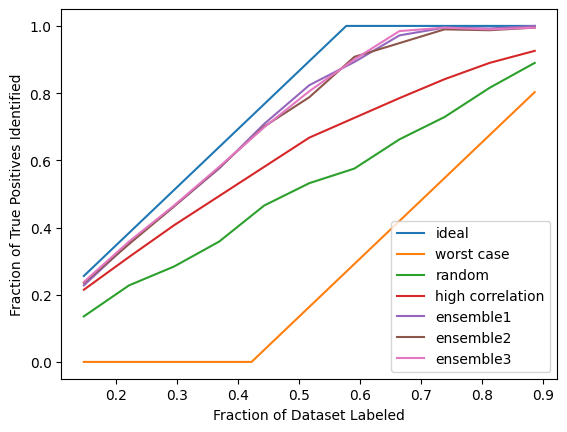

In [14]:
percent_counts = np.array(label_counts)/template_output_count
percent_counts_bounds = np.array(label_counts_bounds)/template_output_count
plt.figure()
plt.plot(percent_counts_bounds, ideal, label="ideal")
plt.plot(percent_counts_bounds, worst_case, label="worst case")
plt.plot(percent_counts, exp1_tp_rate, label="random")
plt.plot(percent_counts, exp2_tp_rate, label="high correlation")
# 20-80
plt.plot(percent_counts, exp3_tp_rate, label="ensemble1")
plt.plot(percent_counts, exp4_tp_rate, label="ensemble2")
plt.plot(percent_counts, exp5_tp_rate, label="ensemble3")
# 50-50
#plt.plot(percent_counts, exp6_tp_rate, label="exp6")
#plt.plot(percent_counts, exp7_tp_rate, label="exp7")
#plt.plot(percent_counts, exp8_tp_rate, label="exp8")
# 10-90
#plt.plot(percent_counts, exp9_tp_rate, label="exp9")
#plt.plot(percent_counts, exp10_tp_rate, label="exp10")
#plt.plot(percent_counts, exp11_tp_rate, label="exp11")
# 30-70
#plt.plot(percent_counts, exp12_tp_rate, label="exp12")
#plt.plot(percent_counts, exp13_tp_rate, label="exp13")
#plt.plot(percent_counts, exp14_tp_rate, label="exp14")
plt.legend()
plt.ylabel("Fraction of True Positives Identified")
plt.xlabel("Fraction of Dataset Labeled")
#plt.title("True Positives Identified vs. Amount of Data Labeled\n Species: Common Poorwill \n n=677 ; tp_count=391")
plt.savefig("ICLR_Visuals/poorwill_no_title.png")

## Identifying the best split

In [15]:
#import scipy
#print("Ideal Area Under the Curve: ", scipy.integrate.simpson( ideal, x=percent_counts))

In [16]:
#train_percentages = np.arange(.1,.91,.05)

In [17]:
#random_ensemble_train_aucs = []
#for train_percentage in train_percentages:
#    cur_tp_rates = train_ensemble_random_data(poorwill_df, label_counts, b, a, default_duration=1.0, train_rate=train_percentage)
#    cur_auc = scipy.integrate.simpson( cur_tp_rates, x=percent_counts)
#    random_ensemble_train_aucs.append(cur_auc)

In [18]:
#print("Max Area Under the Curve for Training Ensemble w/ Random Data: ", 
#      np.max(random_ensemble_train_aucs))

In [19]:
#plt.figure()
#plt.plot(train_percentages, random_ensemble_train_aucs)
#plt.title("Train-test Split Sweep\nRandom Training Ensemble")
#plt.xlabel("% Training Data Percentage")
#plt.ylabel("Area Under Label Count Curve")

In [20]:
#high_low_corr_split_ensemble_train_aucs = []
#for train_percentage in train_percentages:
#    cur_tp_rates = train_ensemble_high_low_corr_split(poorwill_df, label_counts, b, a, 
#                                                      default_duration=1.0, train_rate=train_percentage)
#    cur_auc = scipy.integrate.simpson( cur_tp_rates, x=percent_counts)
#    high_low_corr_split_ensemble_train_aucs.append(cur_auc)

In [21]:
#print("Max Area Under the Curve for Training Ensemble w/ High-low Correlation Split: ", 
#      np.max(high_low_corr_split_ensemble_train_aucs))

In [22]:
#plt.figure()
#plt.plot(train_percentages, high_low_corr_split_ensemble_train_aucs)
#plt.title("Train-test Split Sweep\nHigh-low Correlation Training Ensemble")
#plt.xlabel("% Training Data Percentage")
#plt.ylabel("Area Under Label Count Curve")

In [23]:
#high_low_random_corr_split_ensemble_train_aucs = []
#for train_percentage in train_percentages:
#    cur_tp_rates = train_ensemble_high_low_random_corr_split(poorwill_df, label_counts, b, a, 
#                                                             default_duration=1.0, train_rate=train_percentage)
#    cur_auc = scipy.integrate.simpson( cur_tp_rates, x=percent_counts)
#    high_low_random_corr_split_ensemble_train_aucs.append(cur_auc)

In [24]:
#print("Max Area Under the Curve for Training Ensemble w/ High-low-random Correlation Split: ", 
#      np.max(high_low_random_corr_split_ensemble_train_aucs))

In [25]:
#plt.figure()
#plt.plot(train_percentages, high_low_random_corr_split_ensemble_train_aucs)
#plt.title("Train-test Split Sweep\nHigh-low-random Correlation Training Ensemble")
#plt.xlabel("% Training Data Percentage")
#plt.ylabel("Area Under Label Count Curve")

## Same Experiments Accomplished in MDD Peru on the Bright-rumped Attilla

In [26]:
isolation_parameters = {
    "model" : "template_matching",
    # we will be modifying this for each path
    "template_path" : "",
    "technique" : "steinberg",
    # ideally this is the length of the template in seconds
    "window_size" : 2.0,
    "threshold_type" : "pure",
    "threshold_const" : 0.20,
    "cutoff_freq_low" : 1000,
    "cutoff_freq_high" : 3500,
    "verbose" : True,
    "write_confidence" : True
}
normalized_sample_rate = 8000
# creating the bandpass filter
b, a = butter_bandpass(isolation_parameters['cutoff_freq_low'], 
                       isolation_parameters['cutoff_freq_high'], normalized_sample_rate, order=10)

In [27]:
attilla_df = pd.read_csv("sustech_csvs_labeled/GRABADOR-SDZG-AM-1_ATTILLA_single_w_confidences.csv")
attilla_df = attilla_df[attilla_df["CONFIDENCE"] > isolation_parameters["threshold_const"]]
total_tp_count, total_fp_count = tp_fp_counts(attilla_df, "ATTILLA")
template_output_count = len(attilla_df)
print("Template Matching Output Count w/ Confidence threshold 0.2 - ", template_output_count)
print("True Positive Count - ", total_tp_count)
print("False Positive Count - ", total_fp_count)
print("Precision - ", round(total_tp_count/(total_tp_count+total_fp_count),4))

Template Matching Output Count w/ Confidence threshold 0.2 -  899
True Positive Count -  644
False Positive Count -  255
Precision -  0.7164


In [28]:
label_counts = [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]
# ordering the dataframe based on template confidence values (ascending order)
attilla_df = attilla_df.sort_values("CONFIDENCE")

## Ideal and Worst Case for Attilla

In [29]:
label_counts_bounds = np.arange(100,801)
ideal = np.array(label_counts_bounds)/total_tp_count
ideal[ideal > 1] = 1
worst_case = (np.array(label_counts_bounds) - total_fp_count)/total_tp_count
worst_case[worst_case < 0] = 0

## Random Labeling

In [30]:
exp1_tp_rate = []
for label_count in label_counts:
    #label_indices = random.sample( range(template_output_count), label_count)
    labeled_df = attilla_df.sample(n=label_count)
    cur_tp_count, cur_fp_count = tp_fp_counts(labeled_df, species="ATTILLA")
    exp1_tp_rate.append(cur_tp_count/total_tp_count)

## Top Correlation Labeling

In [31]:
exp2_tp_rate = []
for label_count in label_counts:
    labeled_df = attilla_df.tail(label_count)
    
    cur_tp_count, cur_fp_count = tp_fp_counts(labeled_df, species="ATTILLA")
    exp2_tp_rate.append(cur_tp_count/total_tp_count)
    

## Random Labeling Ensemble Training

In [32]:
exp3_tp_rate = train_ensemble_random_data(attilla_df, label_counts, b, a, default_duration=3.0, species="ATTILLA")

In [33]:
exp4_tp_rate = train_ensemble_high_low_corr_split(attilla_df, label_counts, b, a, default_duration=3.0, species="ATTILLA")

In [34]:
exp5_tp_rate = train_ensemble_high_low_random_corr_split(attilla_df, label_counts, b, a, default_duration=3.0, species="ATTILLA")

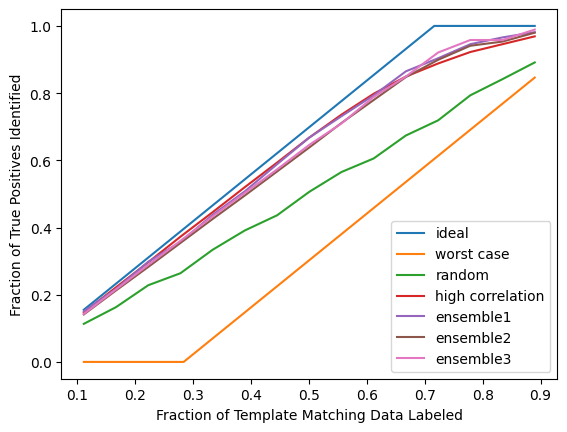

In [35]:
percent_counts = np.array(label_counts)/template_output_count
percent_counts_bounds = np.array(label_counts_bounds)/template_output_count
plt.figure()
plt.plot(percent_counts_bounds, ideal, label="ideal")
plt.plot(percent_counts_bounds, worst_case, label="worst case")
plt.plot(percent_counts, exp1_tp_rate, label="random")
plt.plot(percent_counts, exp2_tp_rate, label="high correlation")
# 20-80
plt.plot(percent_counts, exp3_tp_rate, label="ensemble1")
plt.plot(percent_counts, exp4_tp_rate, label="ensemble2")
plt.plot(percent_counts, exp5_tp_rate, label="ensemble3")
# 50-50
#plt.plot(percent_counts, exp6_tp_rate, label="exp6")
#plt.plot(percent_counts, exp7_tp_rate, label="exp7")
#plt.plot(percent_counts, exp8_tp_rate, label="exp8")
# 10-90
#plt.plot(percent_counts, exp9_tp_rate, label="exp9")
#plt.plot(percent_counts, exp10_tp_rate, label="exp10")
#plt.plot(percent_counts, exp11_tp_rate, label="exp11")
# 30-70
#plt.plot(percent_counts, exp12_tp_rate, label="exp12")
#plt.plot(percent_counts, exp13_tp_rate, label="exp13")
#plt.plot(percent_counts, exp14_tp_rate, label="exp14")
plt.legend(loc="lower right")
plt.ylabel("Fraction of True Positives Identified")
plt.xlabel("Fraction of Template Matching Data Labeled")
#plt.title("True Positives Identified vs. Amount of Data Labeled\n Species: Bright-rumped Attilla \n n=899 ; tp_count=644")
plt.savefig("ICLR_Visuals/attilla_no_title.png")

In [36]:
#print("Ideal Area Under the Curve: ", scipy.integrate.simpson( ideal, x=percent_counts))

In [37]:
#random_ensemble_train_aucs = []
#for train_percentage in train_percentages:
#    cur_tp_rates = train_ensemble_random_data(attilla_df, label_counts, b, a, default_duration=3.0, 
#                                              train_rate=train_percentage, species="ATTILLA")
#    cur_auc = scipy.integrate.simpson( cur_tp_rates, x=percent_counts)
#    random_ensemble_train_aucs.append(cur_auc)

In [38]:
#print("Max Area Under the Curve for Training Ensemble w/ Random Data: ", 
#      np.max(random_ensemble_train_aucs))

In [39]:
#plt.figure()
#plt.plot(train_percentages, random_ensemble_train_aucs)
#plt.title("Train-test Split Sweep\nRandom Training Ensemble")
#plt.xlabel("Training Data Fraction")
#plt.ylabel("Area Under Label Count Curve")

In [40]:
#high_low_corr_split_ensemble_train_aucs = []
#for train_percentage in train_percentages:
#    cur_tp_rates = train_ensemble_high_low_corr_split(attilla_df, label_counts, b, a, default_duration=3.0,
#                                                      train_rate=train_percentage, species="ATTILLA")
#    cur_auc = scipy.integrate.simpson( cur_tp_rates, x=percent_counts)
#    high_low_corr_split_ensemble_train_aucs.append(cur_auc)

In [41]:
#print("Max Area Under the Curve for Training Ensemble w/ High-low Correlation Split: ", 
#      np.max(high_low_corr_split_ensemble_train_aucs))

In [42]:
#plt.figure()
#plt.plot(train_percentages, high_low_corr_split_ensemble_train_aucs)
#plt.title("Train-test Split Sweep\nHigh-low Correlation Training Ensemble")
#plt.xlabel("% Training Data Percentage")
#plt.ylabel("Area Under Label Count Curve")

In [43]:
#high_low_random_corr_split_ensemble_train_aucs = []
#for train_percentage in train_percentages:
#    cur_tp_rates = train_ensemble_high_low_random_corr_split(attilla_df, label_counts, b, a, default_duration=3.0,
#                                                             train_rate=train_percentage, species="ATTILLA")
#    cur_auc = scipy.integrate.simpson( cur_tp_rates, x=percent_counts)
#    high_low_random_corr_split_ensemble_train_aucs.append(cur_auc)

In [44]:
#print("Max Area Under the Curve for Training Ensemble w/ High-low-random Correlation Split: ", 
#      np.max(high_low_random_corr_split_ensemble_train_aucs))

In [45]:
#plt.figure()
#plt.plot(train_percentages, high_low_random_corr_split_ensemble_train_aucs)
#plt.title("Train-test Split Sweep\nHigh-low-random Correlation Training Ensemble")
#plt.xlabel("% Training Data Percentage")
#plt.ylabel("Area Under Label Count Curve")

# Screaming Piha Experiments

In [46]:
isolation_parameters = {
    "model" : "template_matching",
    # we will be modifying this for each path
    "template_path" : "",
    "technique" : "steinberg",
    # ideally this is the length of the template in seconds
    "window_size" : 4.2,
    "threshold_type" : "pure",
    "threshold_const" : 0.20,
    "cutoff_freq_low" : 850,
    "cutoff_freq_high" : 5600,
    "verbose" : True,
    "write_confidence" : True
}
normalized_sample_rate = 12000
# creating the bandpass filter
b, a = butter_bandpass(isolation_parameters['cutoff_freq_low'], 
                       isolation_parameters['cutoff_freq_high'], normalized_sample_rate, order=10)

In [47]:
piha_df = pd.read_csv("sustech_csvs_labeled/GRABADOR-SDZG-AM-1_PIHA_single_w_confidences.csv")
piha_df = piha_df[piha_df["CONFIDENCE"] > isolation_parameters["threshold_const"]]
total_tp_count, total_fp_count = tp_fp_counts(piha_df, "PIHA")
template_output_count = len(piha_df)
print("Template Matching Output Count w/ Confidence threshold 0.2 - ", template_output_count)
print("True Positive Count - ", total_tp_count)
print("False Positive Count - ", total_fp_count)
print("Precision - ", round(total_tp_count/(total_tp_count+total_fp_count),4))

Template Matching Output Count w/ Confidence threshold 0.2 -  800
True Positive Count -  426
False Positive Count -  362
Precision -  0.5406


In [48]:
label_counts = [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]
# ordering the dataframe based on template confidence values (ascending order)
piha_df = piha_df.sort_values("CONFIDENCE")

## Ideal and Worst Case for Piha

In [49]:
label_counts_bounds = np.arange(100,701)
ideal = np.array(label_counts_bounds)/total_tp_count
ideal[ideal > 1] = 1
worst_case = (np.array(label_counts_bounds) - total_fp_count)/total_tp_count
worst_case[worst_case < 0] = 0

## Random Labeling

In [50]:
exp1_tp_rate = []
for label_count in label_counts:
    #label_indices = random.sample( range(template_output_count), label_count)
    labeled_df = piha_df.sample(n=label_count)
    cur_tp_count, cur_fp_count = tp_fp_counts(labeled_df, species="PIHA")
    exp1_tp_rate.append(cur_tp_count/total_tp_count)

## Top Correlation Labeling

In [51]:
exp2_tp_rate = []
for label_count in label_counts:
    labeled_df = piha_df.tail(label_count)
    
    cur_tp_count, cur_fp_count = tp_fp_counts(labeled_df, species="PIHA")
    exp2_tp_rate.append(cur_tp_count/total_tp_count)


In [52]:
exp3_tp_rate = train_ensemble_random_data(piha_df, label_counts, b, a, default_duration=4.5, species="PIHA")

In [53]:
exp4_tp_rate = train_ensemble_high_low_corr_split(piha_df, label_counts, b, a, default_duration=4.5, species="PIHA")

In [54]:
exp5_tp_rate = train_ensemble_high_low_random_corr_split(piha_df, label_counts, b, a, default_duration=4.5, species="PIHA")

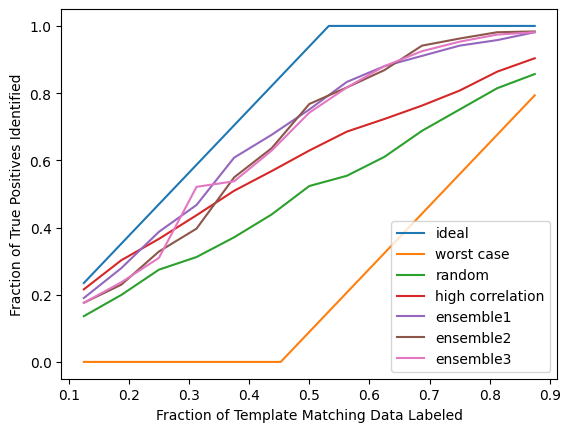

In [55]:
percent_counts = np.array(label_counts)/template_output_count
percent_counts_bounds = np.array(label_counts_bounds)/template_output_count
plt.figure()
plt.plot(percent_counts_bounds, ideal, label="ideal")
plt.plot(percent_counts_bounds, worst_case, label="worst case")
plt.plot(percent_counts, exp1_tp_rate, label="random")
plt.plot(percent_counts, exp2_tp_rate, label="high correlation")
# 20-80
plt.plot(percent_counts, exp3_tp_rate, label="ensemble1")
plt.plot(percent_counts, exp4_tp_rate, label="ensemble2")
plt.plot(percent_counts, exp5_tp_rate, label="ensemble3")

plt.legend()
plt.ylabel("Fraction of True Positives Identified")
plt.xlabel("Fraction of Template Matching Data Labeled")
#plt.title("True Positives Identified vs. Amount of Data Labeled\n Species: Screaming Piha \n n=800 ; tp_count=426")
plt.savefig("ICLR_Visuals/piha_no_title.png")

In [56]:
#print("Ideal Area Under the Curve: ", scipy.integrate.simpson( ideal, x=percent_counts))

In [57]:
#random_ensemble_train_aucs = []
#for train_percentage in train_percentages:
#    cur_tp_rates = train_ensemble_random_data(piha_df, label_counts, b, a, default_duration=4.5, 
#                                              train_rate=train_percentage, species="PIHA")
#    cur_auc = scipy.integrate.simpson( cur_tp_rates, x=percent_counts)
#    random_ensemble_train_aucs.append(cur_auc)

In [58]:
#print("Max Area Under the Curve for Training Ensemble w/ Random Data: ", 
#      np.max(random_ensemble_train_aucs))

In [59]:
#plt.figure()
#plt.plot(train_percentages, random_ensemble_train_aucs)
#plt.title("Train-test Split Sweep\nRandom Training Ensemble")
#plt.xlabel("% Training Data Percentage")
#plt.ylabel("Area Under Label Count Curve")

In [60]:
#high_low_corr_split_ensemble_train_aucs = []
#for train_percentage in train_percentages:
#    cur_tp_rates = train_ensemble_high_low_corr_split(piha_df, label_counts, b, a, default_duration=4.5,
#                                                      train_rate=train_percentage, species="PIHA")
#    cur_auc = scipy.integrate.simpson( cur_tp_rates, x=percent_counts)
#    high_low_corr_split_ensemble_train_aucs.append(cur_auc)

In [61]:
#print("Max Area Under the Curve for Training Ensemble w/ High-low Correlation Split: ", 
#      np.max(high_low_corr_split_ensemble_train_aucs))

In [62]:
#plt.figure()
#plt.plot(train_percentages, high_low_corr_split_ensemble_train_aucs)
#plt.title("Train-test Split Sweep\nHigh-low Correlation Training Ensemble")
#plt.xlabel("% Training Data Percentage")
#plt.ylabel("Area Under Label Count Curve")

In [63]:
#high_low_random_corr_split_ensemble_train_aucs = []
#for train_percentage in train_percentages:
#    cur_tp_rates = train_ensemble_high_low_random_corr_split(piha_df, label_counts, b, a, default_duration=4.5,
#                                                             train_rate=train_percentage, species="PIHA")
#    cur_auc = scipy.integrate.simpson( cur_tp_rates, x=percent_counts)
#    high_low_random_corr_split_ensemble_train_aucs.append(cur_auc)

In [64]:
#print("Max Area Under the Curve for Training Ensemble w/ High-low-random Correlation Split: ", 
#      np.max(high_low_random_corr_split_ensemble_train_aucs))

In [65]:
#plt.figure()
#plt.plot(train_percentages, high_low_random_corr_split_ensemble_train_aucs)
#plt.title("Train-test Split Sweep\nHigh-low-random Correlation Training Ensemble")
#plt.xlabel("% Training Data Percentage")
#plt.ylabel("Area Under Label Count Curve")